In [2]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import scipy.optimize as so
from tqdm import tqdm

import time
import copy

import corner

import dart_board
from dart_board import constants as c
from dart_board.pop_synth.cosmic_wrapper import evolve
from dart_board.utils import A_to_P

import sys
sys.path.append("../code/")
from probabilities import infile, load_LIGO_dat, nlog_likelihood
from probabilities import my_function_Z, findTotalLikelihood
load_LIGO_dat(infile)

figure_dir = '../figures/'

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'serif'

SMALL_SIZE = 11
MEDIUM_SIZE = 11
BIGGER_SIZE = 11
mpl.rc('font', size=SMALL_SIZE)          # controls default text sizes
mpl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
mpl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
mpl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
mpl.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

### Helper functions

In [3]:
def hist2d(x, y, xrange=None, yrange=None, bins=30, color='C0', filled=True, quad=True, levels=None, ax=None):

    # Need this function
    def find_confidence_interval(x, pdf, confidence_level):
        return pdf[pdf > x].sum() - confidence_level
    

    if xrange is None: xrange = [min(x), max(x)]    
    if yrange is None: yrange = [min(y), max(y)]
    
    data_range = (xrange, yrange)
    H, xedges, yedges = np.histogram2d(x, y, bins=(bins,bins), 
                                       range=data_range, normed=True)

    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,bins))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((bins,1))
    pdf = (H*(x_bin_sizes*y_bin_sizes))

    if levels is None:
        if quad: 
            levels = [0.25, 0.5, 0.75]
        else:
            levels = [0.68, 0.95, 0.99]
        
    level_1 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, levels[0]))
    level_2 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, levels[1]))
    if len(levels) > 2:
        level_3 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, levels[2]))
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    
    
    if not ax is None: 
        plot = ax
    else:
        plot = plt
        
    
    if filled:
        if len(levels) > 2:
            # Plot contours
            levels = [1.0, level_1, level_2, level_3]
            contour = plot.contourf(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                                    alpha=0.3)
        # Plot contours
        levels = [1.0, level_1, level_2]
        contour = plot.contourf(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                                alpha=0.3)
        # Plot contours
        levels = [1.0, level_1]
        contour = plot.contourf(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                                alpha=0.3)
    else:
        if len(levels) > 2:
            # Plot contours
            levels = [1.0, level_1, level_2, level_3]
            contour = plot.contour(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                                   alpha=0.3)
        # Plot contours
        levels = [1.0, level_1, level_2]
        contour = plot.contour(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                               alpha=0.3)
        # Plot contours
        levels = [1.0, level_1]
        contour = plot.contour(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                               alpha=0.3)
        
        
        
def corner_2(models, colors, ranges, labels, ax=None, points=None, points_colors=None):
    
    n_data, n_var = models[0].shape
    
    if ax is None:
        fig, ax = plt.subplots(n_var, n_var, figsize=(8,8))

    for x in range(n_var):
        for y in range(n_var):
            for i in range(n_var-1):
                if x == i and y > i: ax[x,y].axis('off')

            ax[x,y].set_xlim(ranges[y][0], ranges[y][1])

            if y < x:
                ax[x,y].set_ylim(ranges[x][0], ranges[x][1])
                if y == 0:
                    ax[x,y].set_ylabel(labels[x])
                else:
                    ax[x,y].set_yticklabels([])
                if x == n_var-1:
                    ax[x,y].set_xlabel(labels[y])
                else:
                    ax[x,y].set_xticklabels([])
            else:
                if x != n_var-1 and y != n_var-1:
                    ax[x,y].set_xticklabels([])            
                ax[x,y].set_yticklabels([])   

            if x == n_var-1 and y == n_var-1:
                ax[x,y].set_xlabel(labels[y])

            if x == y:
                ax[x,y].set_yticklabels([])



    for x in range(n_var):
        for y in range(n_var):
            if x == y:
                for i, model in enumerate(models):
                    color = colors[i]
                        
                    ax[x,y].hist(model[:,x], 
                                 range=ranges[x], 
                                 bins=30, 
                                 histtype='step',
                                 color=color,
                                 density=True)


            if y < x:
                for i, model in enumerate(models):
                    color = colors[i]


                    hist2d(model[:,y], 
                           model[:,x], 
                           xrange=ranges[y], 
                           yrange=ranges[x], 
                           ax=ax[x,y],
                           color=color,
                           levels=[0.5, 0.9],
                           filled=True)
                    
                    if points is not None:
                        if points_colors is None:
                            ax[x,y].scatter(points[:,y], points[:,x], color='k', marker='.', s=50)
                        else:
                            ax[x,y].scatter(points[:,y], points[:,x], c=points_colors, marker='.', s=50)
                  
    tmp_x = np.linspace(0, 1000, 10)
    ax[1,0].plot(tmp_x, tmp_x, color='k', linestyle='dashed')

### Load up data

In [4]:
data_dir = "/Users/andrews/Research/dart_projects/LIGO/data/150914_new/"

def get_flattened_data(root, model, PT=False):

    chains = np.load(data_dir + root + '_chains_' + model + '.npy')
    derived = np.load(data_dir + root + '_derived_' + model + '.npy')
    
    if PT:
        chains = chains[:,:,100:,:]
        derived = derived[:,:,100:]
        n_temps, n_walkers, n_steps, n_var = chains.shape        
        chains = chains[0].reshape((n_walkers*n_steps, n_var))
        derived = derived[0].reshape((n_walkers*n_steps))

    else:
        chains = chains[:,100:,:]
        derived = derived[:,100:]
        n_walkers, n_steps, n_var = chains.shape
        chains = chains.reshape((n_walkers*n_steps, n_var))
        derived = derived.reshape((n_walkers*n_steps))
        
    chains[:,0] = np.exp(chains[:,0])
    chains[:,1] = np.exp(chains[:,1])
    chains[:,2] = np.log10(np.exp(chains[:,2]))
    chains[:,-1] = np.log10(np.exp(chains[:,-1]))

    condensed = chains[:,[0,1,2,3,-1]]
    
    return chains, derived, condensed



# facc1_chains, facc1_derived, facc1_condensed = get_flattened_data('150914', 'facc1') 
# alph05_chains, alph05_derived, alph05_condensed = get_flattened_data('150914', 'alph0.5')
# alph5_chains, alph5_derived, alph5_condensed = get_flattened_data('150914', 'alph5')
# cemerge1_chains, cemerge1_derived, cemerge1_condensed = get_flattened_data('150914', 'cemerge1')
# qc2_chains, qc2_derived, qc2_condensed = get_flattened_data('150914', 'qc2')
# std_chains, std_derived, std_condensed = get_flattened_data('150914', 'std')
# sig150_chains, sig150_derived, sig150_condensed = get_flattened_data('150914', 'sig150')


facc1_BHBH_chains, facc1_BHBH_derived, facc1_BHBH_condensed = get_flattened_data('BHBH', 'facc1') 
alph05_BHBH_chains, alph05_BHBH_derived, alph05_BHBH_condensed = get_flattened_data('BHBH', 'alph0.5')
alph5_BHBH_chains, alph5_BHBH_derived, alph5_BHBH_condensed = get_flattened_data('BHBH', 'alph5')
cemerge1_BHBH_chains, cemerge1_BHBH_derived, cemerge1_BHBH_condensed = get_flattened_data('BHBH', 'cemerge1')
qc2_BHBH_chains, qc2_BHBH_derived, qc2_BHBH_condensed = get_flattened_data('BHBH', 'qc2')
std_BHBH_chains, std_BHBH_derived, std_BHBH_condensed = get_flattened_data('BHBH', 'std')
sig150_BHBH_chains, sig150_BHBH_derived, sig150_BHBH_condensed = get_flattened_data('BHBH', 'sig150')


alph5_short_chains, alph5_short_derived, alph5_short_condensed = get_flattened_data('150914', 'alph5_short')
cemerge1_short_chains, cemerge1_short_derived, cemerge1_short_condensed = get_flattened_data('150914', 'cemerge1_short')
alph05_short_chains, alph05_short_derived, alph05_short_condensed = get_flattened_data('150914', 'alph0.5_short')
facc1_short_chains, facc1_short_derived, facc1_short_condensed = get_flattened_data('150914', 'facc1_short')
sig150_short_chains, sig150_short_derived, sig150_short_condensed = get_flattened_data('150914', 'sig150_short')
std_short_chains, std_short_derived, std_short_condensed = get_flattened_data('150914', 'std_short')
qc2_short_chains, qc2_short_derived, qc2_short_condensed = get_flattened_data('150914', 'qc2_short')

alph5_long_chains, alph5_long_derived, alph5_long_condensed = get_flattened_data('150914', 'alph5_long')
cemerge1_long_chains, cemerge1_long_derived, cemerge1_long_condensed = get_flattened_data('150914', 'cemerge1_long')
alph05_long_chains, alph05_long_derived, alph05_long_condensed = get_flattened_data('150914', 'alph0.5_long')
facc1_long_chains, facc1_long_derived, facc1_long_condensed = get_flattened_data('150914', 'facc1_long')
sig150_long_chains, sig150_long_derived, sig150_long_condensed = get_flattened_data('150914', 'sig150_long')
std_long_chains, std_long_derived, std_long_condensed = get_flattened_data('150914', 'std_long')
qc2_long_chains, qc2_long_derived, qc2_long_condensed = get_flattened_data('150914', 'qc2_long')

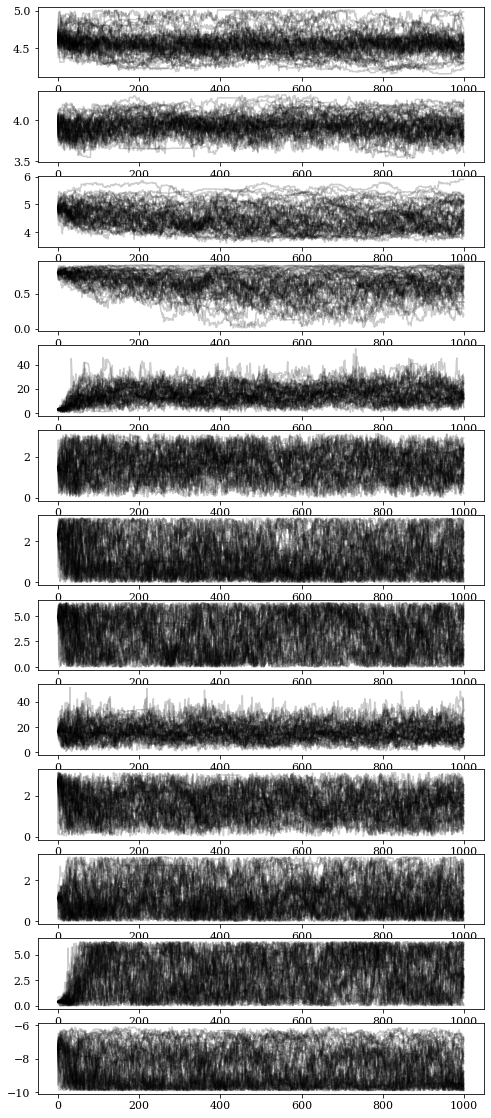

In [5]:
fig, ax = plt.subplots(13, 1, figsize=(8,20))

chains = np.load(data_dir + '150914_chains_std_short.npy')
n_walkers, n_steps, n_var = chains.shape

for i in range(n_var):
    for j in range(50):
        ax[i].plot(chains[j,:,i], color='k', alpha=0.2)
        
        
plt.show()

In [6]:
data_dir = "/Users/andrews/Research/dart_projects/LIGO/data/150914_PT/"

def get_flattened_data(root, model, derived=True, PT=False):

    if PT:
        chains = np.load(data_dir + root + '_chains_' + model + '_PT.npy')
        chains = chains[:,:,100:,:]
    else:
        chains = np.load(data_dir + root + '_chains_' + model + '.npy')        
        chains = chains[:,100:,:]
    if derived:
        if PT:
            derived_data = np.load(data_dir + root + '_derived_' + model + '_PT.npy')
            MT_data = np.load(data_dir + root + '_derived_' + model + '_MT_PT.npy')
            derived_data = derived_data[:,:,100:]
            MT_data = MT_data[:,:,100:]
        else:
            derived_data = np.load(data_dir + root + '_derived_' + model + '.npy')
            MT_data = np.load(data_dir + root + '_derived_' + model + '_MT.npy')
            derived_data = derived_data[:,100:]
            MT_data = MT_data[:,100:]
            
    if PT:
        n_temps, n_walkers, n_steps, n_var = chains.shape        
        chains = chains[0].reshape((n_walkers*n_steps, n_var))
        if derived:
            derived_data = derived_data[0].reshape((n_walkers*n_steps))
            MT_data = MT_data[0].reshape((n_walkers*n_steps))

    else:
        n_walkers, n_steps, n_var = chains.shape
        chains = chains.reshape((n_walkers*n_steps, n_var))
        if derived:
            derived_data = derived_data.reshape((n_walkers*n_steps))
            MT_data = MT_data.reshape((n_walkers*n_steps))
                
    chains[:,0] = np.exp(chains[:,0])
    chains[:,1] = np.exp(chains[:,1])
    chains[:,2] = np.log10(np.exp(chains[:,2]))
    chains[:,-1] = np.log10(np.exp(chains[:,-1]))

    condensed = chains[:,[0,1,2,3,-1]]
    
    if derived:
        if PT:
            return chains, derived_data, condensed, MT_data
        else:
            return chains, derived_data, condensed, MT_data
    else:
        return chains, condensed

In [7]:
chains_std_short, derived_std_short, condensed_std_short, MT_std_short = get_flattened_data("150914", "std_short", PT=True)
chains_std_long, derived_std_long, condensed_std_long, MT_std_long = get_flattened_data("150914", "std_long", PT=True)

chains_alph05_short, derived_alph05_short, condensed_alph05_short, MT_alph05_short = get_flattened_data("150914", "alph0.5_short", PT=True)
chains_alph05_long, derived_alph05_long, condensed_alph05_long, MT_alph05_long = get_flattened_data("150914", "alph0.5_long", PT=True)

chains_alph5_short, derived_alph5_short, condensed_alph5_short, MT_alph5_short = get_flattened_data("150914", "alph5_short", PT=True)
chains_alph5_long, derived_alph5_long, condensed_alph5_long, MT_alph5_long = get_flattened_data("150914", "alph5_long", PT=True)

chains_cemerge1_short, derived_cemerge1_short, condensed_cemerge1_short, MT_cemerge1_short = get_flattened_data("150914", "cemerge1_short", PT=True)
chains_cemerge1_long, derived_cemerge1_long, condensed_cemerge1_long, MT_cemerge1_long = get_flattened_data("150914", "cemerge1_long", PT=True)

chains_facc1_short, derived_facc1_short, condensed_facc1_short, MT_facc1_short = get_flattened_data("150914", "facc1_short", PT=True)
chains_facc1_long, derived_facc1_long, condensed_facc1_long, MT_facc1_long = get_flattened_data("150914", "facc1_long", PT=True)

chains_qc2_short, derived_qc2_short, condensed_qc2_short, MT_qc2_short = get_flattened_data("150914", "qc2_short", PT=True)
chains_qc2_long, derived_qc2_long, condensed_qc2_long, MT_qc2_long = get_flattened_data("150914", "qc2_long", PT=True)

chains_sig150_short, derived_sig150_short, condensed_sig150_short, MT_sig150_short = get_flattened_data("150914", "sig150_short", PT=True)
chains_sig150_long, derived_sig150_long, condensed_sig150_long, MT_sig150_long = get_flattened_data("150914", "sig150_long", PT=True)




std_BHBH_chains, std_BHBH_derived, std_BHBH_condensed, std_BHBH_MT = get_flattened_data('../150914_new/BHBH', 'std')
alph05_BHBH_chains, alph05_BHBH_derived, alph05_BHBH_condensed, alph05_BHBH_MT = get_flattened_data('../150914_new/BHBH', 'alph0.5')
alph5_BHBH_chains, alph5_BHBH_derived, alph5_BHBH_condensed, alph5_BHBH_MT = get_flattened_data('../150914_new/BHBH', 'alph5')
cemerge1_BHBH_chains, cemerge1_BHBH_derived, cemerge1_BHBH_condensed, cemerge1_BHBH_MT = get_flattened_data('../150914_new/BHBH', 'cemerge1')
facc1_BHBH_chains, facc1_BHBH_derived, facc1_BHBH_condensed, facc1_BHBH_MT = get_flattened_data('../150914_new/BHBH', 'facc1')
qc2_BHBH_chains, qc2_BHBH_derived, qc2_BHBH_condensed, qc2_BHBH_MT = get_flattened_data('../150914_new/BHBH', 'qc2')
sig150_BHBH_chains, sig150_BHBH_derived, sig150_BHBH_condensed, sig150_BHBH_MT = get_flattened_data('../150914_new/BHBH', 'sig150')



chains_short = [chains_std_short, chains_alph05_short, chains_alph5_short, chains_cemerge1_short, 
                chains_facc1_short, chains_qc2_short, chains_sig150_short]
chains_long = [chains_std_long, chains_alph05_long, chains_alph5_long, chains_cemerge1_long, 
               chains_facc1_long, chains_qc2_long, chains_sig150_long]
deriveds_short = [derived_std_short, derived_alph05_short, derived_alph5_short, derived_cemerge1_short, 
                  derived_facc1_short, derived_qc2_short, derived_sig150_short]
deriveds_long = [derived_std_long, derived_alph05_long, derived_alph5_long, derived_cemerge1_long, 
                 derived_facc1_long, derived_qc2_long, derived_sig150_long]
MTs_short = [MT_std_short, MT_alph05_short, MT_alph5_short, MT_cemerge1_short, 
             MT_facc1_short, MT_qc2_short, MT_sig150_short]
MTs_long = [MT_std_long, MT_alph05_long, MT_alph5_long, MT_cemerge1_long, 
            MT_facc1_long, MT_qc2_long, MT_sig150_long]

chains = [std_BHBH_chains, alph05_BHBH_chains, alph5_BHBH_chains, cemerge1_BHBH_chains, 
          facc1_BHBH_chains, qc2_BHBH_chains, sig150_BHBH_chains]
deriveds = [std_BHBH_derived, alph05_BHBH_derived, alph5_BHBH_derived, cemerge1_BHBH_derived, 
            facc1_BHBH_derived, qc2_BHBH_derived, sig150_BHBH_derived]
MTs = [std_BHBH_MT, alph05_BHBH_MT, alph5_BHBH_MT, cemerge1_BHBH_MT,
       facc1_BHBH_MT, qc2_BHBH_MT, sig150_BHBH_MT]

### Calculate the likelihoods for the BHBH runs for each model

In [8]:
def calc_likelihood(chains, derived, idx=None):
    
    chains_copy = copy.deepcopy(chains)
    chains_copy[:,-1] = np.log(10**chains_copy[:,-1])

    likelihood = np.zeros(len(chains))

    for i, x in enumerate(chains_copy):
        
        if idx is not None:
            if i not in idx: continue
        
        y = derived[i]
        likelihood[i] = findTotalLikelihood(x, y)

    return likelihood
    


# facc1_BHBH_likelihood = []
# alph05_BHBH_likelihood = []
# alph5_BHBH_likelihood = []
# cemerge1_BHBH_likelihood = []
# qc2_BHBH_likelihood = []
# std_BHBH_likelihood = []
# sig150_BHBH_likelihood = []

# facc1_BHBH_idx = []
# alph05_BHBH_idx = []
# alph5_BHBH_idx = []
# cemerge1_BHBH_idx = []
# qc2_BHBH_idx = []
# std_BHBH_idx = []
# sig150_BHBH_idx = []


# chains = [facc1_BHBH_chains, alph05_BHBH_chains, alph5_BHBH_chains, cemerge1_BHBH_chains,
#           qc2_BHBH_chains, std_BHBH_chains, sig150_BHBH_chains]
# deriveds = [facc1_BHBH_derived, alph05_BHBH_derived, alph5_BHBH_derived, cemerge1_BHBH_derived,
#             qc2_BHBH_derived, std_BHBH_derived, sig150_BHBH_derived]
# likelihoods = [facc1_BHBH_likelihood, alph05_BHBH_likelihood, alph5_BHBH_likelihood, cemerge1_BHBH_likelihood,
#                qc2_BHBH_likelihood, std_BHBH_likelihood, sig150_BHBH_likelihood]
# idxs = [facc1_BHBH_idx, alph05_BHBH_idx, alph5_BHBH_idx, cemerge1_BHBH_idx, qc2_BHBH_idx, 
#         std_BHBH_idx, sig150_BHBH_idx]

    
def find_likelihoods(chains, derived):

    idx = np.intersect1d(np.where(derived['M1'] > 28)[0], np.where(derived['M2'] > 24)[0])
    idx = np.intersect1d(idx, np.where(derived['M1'] < 42)[0])
    idx = np.intersect1d(idx, np.where(derived['M2'] < 38)[0])
    
    idx2 = np.intersect1d(np.where(derived['M2'] > 28)[0], np.where(derived['M1'] > 24)[0])
    idx2 = np.intersect1d(idx2, np.where(derived['M2'] < 42)[0])
    idx2 = np.intersect1d(idx2, np.where(derived['M1'] < 38)[0])    
    
    idx = np.union1d(idx, idx2)
    
    return calc_likelihood(chains, derived, idx), idx


likelihoods = []
idxs = []
# res = find_likelihoods(chains[5], deriveds[5])
# likelihoods.append(res[0])
# idxs.append(res[1])
for chain, derived in zip(chains, deriveds):
    likelihood, idx = find_likelihoods(chain, derived)
    likelihoods.append(likelihood)
    idxs.append(idx)

/opt/anaconda3/envs/dart_ligo/lib/python3.7/site-packages/dart_board/utils.py:185: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  term_3 = quad(integrand_ecc, 0.0, e, epsabs=1.0e-60, epsrel=1.0e-60)[0]
/opt/anaconda3/envs/dart_ligo/lib/python3.7/site-packages/dart_board/utils.py:185: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  term_3 = quad(integrand_ecc, 0.0, e, epsabs=1.0e-60, epsrel=1.0e-60)[0]


KeyboardInterrupt: 

### Calculate the mass transfer scenarios

In [6]:
def calc_scenario(chains, deriveds, MTs):

    scenario = np.array([])
    scenario_colors = np.array([])

    for i, MT_flag in enumerate(MTs):
    

        scenario = np.append(scenario, MT_flag)

        if MT_flag == 1:
            scenario_colors = np.append(scenario_colors,'C0')
        else:
            scenario_colors = np.append(scenario_colors,'C1')
    
    return scenario, scenario_colors




scenario, scenario_colors = calc_scenario(std_BHBH_chains[idxs[0]], 
                                          std_BHBH_derived[idxs[0]],
                                          std_BHBH_MT[idxs[0]])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10


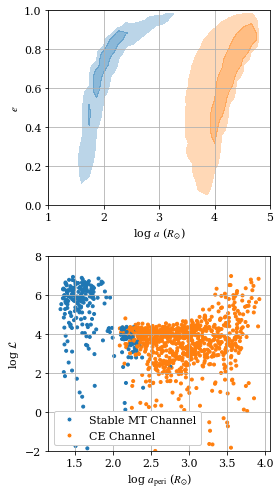

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(4, 7))


# std model
i = 0
chain = chains[i]
short_chain = chains_short[i]
long_chain = chains_long[i]
likelihood = likelihoods[i]

# chain = alph5_BHBH_chains
# short_chain = alph5_short_chains
# long_chain = alph5_long_chains
# likelihood = likelihoods[2]



idx = np.where(MTs_short[i] == 1)[0]
hist2d(short_chain[idx,2], 
       short_chain[idx,3], 
       xrange=(1,5), 
       yrange=(0,1), 
       ax=ax[0],
       color='C0',
       levels=[0.5, 0.9])

idx = np.where(MTs_long[i] != 1)[0]
hist2d(long_chain[idx,2], 
       long_chain[idx,3], 
       xrange=(1,5), 
       yrange=(0,1), 
       ax=ax[0],
       color='C1',
       levels=[0.5, 0.9])



ax[0].set_xlim(1,5)
ax[0].set_ylim(0,1)

ax[0].set_xlabel(r'log $a$ ($R_{\odot}$)')
ax[0].set_ylabel(r'$e$')




# Calculate periastron separation
log_a_peri = np.log10(10**chain[:,2] * (1-chain[:,3]))

# Clean for NaN's
# likelihood[np.where(np.isnan(likelihood))[0]] = 0.0
# idx = np.where(likelihood>1e-2)[0]


log_a_peri = np.log10(10**chain[:,2] * (1-chain[:,3]))
ax[1].scatter(log_a_peri[idxs[0]], np.log10(likelihood[idxs[0]]), marker='.', c=scenario_colors)


legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='C0', markersize=5, 
                         label='Stable MT Channel'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='C1', markersize=5, 
                         label='CE Channel')]

ax[1].legend(handles=legend_elements, loc=3, framealpha=1)





ax[1].set_ylim(-2, 8)

for a in ax:
#     a.set_xlim(1, 5)
    a.grid()

ax[1].set_xlabel(r'log $a_{\rm peri}$ ($R_{\odot}$)')
ax[1].set_ylabel(r'log $\mathcal{L}$')

plt.tight_layout()
plt.savefig(figure_dir + "posterior_check_std.pdf")
# plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


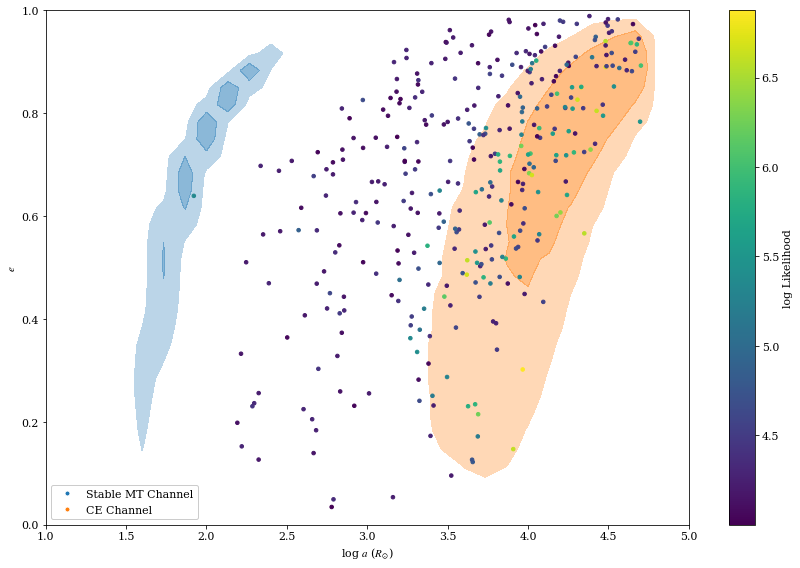

In [9]:
plt.figure(figsize=(12, 8))


# Which model
i = 5
chain = chains[i]
short_chain = chains_short[i]
long_chain = chains_long[i]
likelihood = likelihoods[i]


# chain = std_BHBH_chains
# short_chain = std_short_chains
# long_chain = std_long_chains
# likelihood = likelihoods[0]


ax = plt.gca()


hist2d(short_chain[:,2], 
       short_chain[:,3], 
       xrange=(1,5), 
       yrange=(0,1), 
       ax=ax,
       color='C0',
       levels=[0.5, 0.9])


hist2d(long_chain[:,2], 
       long_chain[:,3], 
       xrange=(1,5), 
       yrange=(0,1), 
       ax=ax,
       color='C1',
       levels=[0.5, 0.9])




idx_good = np.where(np.log10(likelihood[idxs[0]]) > 4)[0]

# for i in range(len(idxs[5])):
plt.scatter(chain[idxs[0],2][idx_good], 
            chain[idxs[0],3][idx_good], 
            marker='.', 
            s=50,
            c=np.log10(likelihood[idxs[0]][idx_good]))



plt.colorbar(label='log Likelihood')



plt.xlim(1,5)
plt.ylim(0,1)

plt.xlabel(r'log $a$ ($R_{\odot}$)')
plt.ylabel(r'$e$')


legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='C0', markersize=5, 
                         label='Stable MT Channel'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='C1', markersize=5, 
                         label='CE Channel')]

plt.legend(handles=legend_elements, loc=3, framealpha=1)


# ax.arrow(3.3, 0.85, -0.3, 0.05, head_width=0.05, head_length=0.1, fc='k', ec='k')
# plt.text(3.3, 0.83, "Case C MT", fontsize=14)

# ax.arrow(2.5, 0.6, -0.3, 0.05, head_width=0.05, head_length=0.1, fc='k', ec='k')
# plt.text(2.5, 0.58, "Case B MT", fontsize=14)



plt.tight_layout()
# plt.savefig(figure_dir + "std_P_orb_ecc_with_points.pdf")
plt.show()

### Calculate table values

In [118]:
print(chains[0][:,-2])

[3.79259923 3.11121547 2.59789194 ... 1.13005938 1.21116778 1.77960328]


In [158]:
def calc_conf_int(x, level=0.9):
    tmp_x = np.sort(x)
    x_mean = tmp_x[int(0.5*len(x))]
    x_low = tmp_x[int((0.5 - level/2)*len(x))]
    x_high = tmp_x[int((0.5 + level/2)*len(x))]
    return x_mean, x_mean-x_low, x_high-x_mean
    
for i in range(7):
    
    chain = chains[i]
    derived = deriveds[i]
    likelihood = likelihoods[i]
    idx = idxs[i]
    MT = MTs[i]
    
    chain_short = chains_short[i]
    derived_short = deriveds_short[i]
    chain_long = chains_long[i]
    derived_long = deriveds_long[i]

    
    f_short = np.nansum(likelihood[MT==1])
    f_long = np.nansum(likelihood[MT!=1])
    f_tot = f_short + f_long
    f_short = f_short / f_tot
    f_long = f_long / f_tot

    # Short a solution
    idx = np.where(MTs_short[i] == 1)[0]
    M1, M1_low_err, M1_high_err = calc_conf_int(chain_short[idx,0])
    M2, M2_low_err, M2_high_err = calc_conf_int(chain_short[idx,1])
    a, a_low_err, a_high_err = calc_conf_int(chain_short[idx,2])
    Z, Z_low_err, Z_high_err = calc_conf_int(chain_short[idx,-1])
    M1_BH, M1_BH_low_err, M1_BH_high_err = calc_conf_int(derived_short[idx]['M1'])
    M2_BH, M2_BH_low_err, M2_BH_high_err = calc_conf_int(derived_short[idx]['M2'])

    if i == 0:
        model = "--"
    elif i == 1:
        model = "$\\alpha_{\\rm CE}=0.5$"
    elif i == 2:
        model = "$\\alpha_{\\rm CE}=5$"
    elif i == 3:
        model = "Pessimistic CE"
    elif i == 4:
        model = "$f_{\\rm acc}=1$"
    elif i == 5:
        model = "$q_{\\rm crit}=2$"
    else:
        model = "$\\sigma_k=150$ km s$^{-1}$"

    if i == 0:
        out = str(i+1) + " (std) & "
    else:
        out = str(i+1) + " & "
    out += model + " & " + "{:.2f}".format(f_short) + " & " 
    out += "{:.0f}".format(M1) + "$^{+" + "{:.0f}".format(M1_high_err) + "}_{-" + "{:.0f}".format(M1_low_err) + "}$ & "
    out += "{:.0f}".format(M2) + "$^{+" + "{:.0f}".format(M2_high_err) + "}_{-" + "{:.0f}".format(M2_low_err) + "}$ & "
    out += "{:.2f}".format(a) + "$^{+" + "{:.2f}".format(a_high_err) + "}_{-" + "{:.2f}".format(a_low_err) + "}$ & "
    out += "{:.2f}".format(Z) + "$^{+" + "{:.2f}".format(Z_high_err) + "}_{-" + "{:.2f}".format(Z_low_err) + "}$ & " 
    out += "{:.1f}".format(M1_BH) + "$^{+" + "{:.1f}".format(M1_BH_high_err) + "}_{-" + "{:.1f}".format(M1_BH_low_err) + "}$ & "
    out += "{:.1f}".format(M2_BH) + "$^{+" + "{:.1f}".format(M2_BH_high_err) + "}_{-" + "{:.1f}".format(M2_BH_low_err) + "}$ "
    out += "\\\\"

    print(out)

print()
    
    
for i in range(7):
    
    chain = chains[i]
    derived = deriveds[i]
    likelihood = likelihoods[i]
    idx = idxs[i]
    MT = MTs[i]
    
    chain_short = chains_short[i]
    derived_short = deriveds_short[i]
    chain_long = chains_long[i]
    derived_long = deriveds_long[i]

    
    f_short = np.nansum(likelihood[MT==1])
    f_long = np.nansum(likelihood[MT!=1])
    f_tot = f_short + f_long
    f_short = f_short / f_tot
    f_long = f_long / f_tot

    # Long a solution
    idx = np.where(MTs_long[i] != 1)[0]
    M1, M1_low_err, M1_high_err = calc_conf_int(chain_long[idx,0])
    M2, M2_low_err, M2_high_err = calc_conf_int(chain_long[idx,1])
    a, a_low_err, a_high_err = calc_conf_int(chain_long[idx,2])
    Z, Z_low_err, Z_high_err = calc_conf_int(chain_long[idx,-1])
    M1_BH, M1_BH_low_err, M1_BH_high_err = calc_conf_int(derived_long[idx]['M1'])
    M2_BH, M2_BH_low_err, M2_BH_high_err = calc_conf_int(derived_long[idx]['M2'])

    if i == 0:
        model = "--"
    elif i == 1:
        model = "$\\alpha_{\\rm CE}=0.5$"
    elif i == 2:
        model = "$\\alpha_{\\rm CE}=5$"
    elif i == 3:
        model = "Pessimistic CE"
    elif i == 4:
        model = "$f_{\\rm acc}=1$"
    elif i == 5:
        model = "$q_{\\rm crit}=2$"
    else:
        model = "$\\sigma_k=150$ km s$^{-1}$"

    
    if i == 0:
        out = str(i+1) + " (std) & "
    else:
        out = str(i+1) + " & "
    out += model + " & " + "{:.2f}".format(f_long) + " & " 
    out += "{:.0f}".format(M1) + "$^{+" + "{:.0f}".format(M1_high_err) + "}_{-" + "{:.0f}".format(M1_low_err) + "}$ & "
    out += "{:.0f}".format(M2) + "$^{+" + "{:.0f}".format(M2_high_err) + "}_{-" + "{:.0f}".format(M2_low_err) + "}$ & "
    out += "{:.2f}".format(a) + "$^{+" + "{:.2f}".format(a_high_err) + "}_{-" + "{:.2f}".format(a_low_err) + "}$ & "
    out += "{:.2f}".format(Z) + "$^{+" + "{:.2f}".format(Z_high_err) + "}_{-" + "{:.2f}".format(Z_low_err) + "}$ & " 
    out += "{:.1f}".format(M1_BH) + "$^{+" + "{:.1f}".format(M1_BH_high_err) + "}_{-" + "{:.1f}".format(M1_BH_low_err) + "}$ & "
    out += "{:.1f}".format(M2_BH) + "$^{+" + "{:.1f}".format(M2_BH_high_err) + "}_{-" + "{:.1f}".format(M2_BH_low_err) + "}$ "
    out += "\\\\"
    
    print(out)
    
    

1 (std) & -- & 0.77 & 96$^{+37}_{-24}$ & 52$^{+16}_{-10}$ & 1.99$^{+0.73}_{-0.31}$ & -3.63$^{+0.81}_{-0.63}$ & 35.0$^{+5.3}_{-5.3}$ & 30.9$^{+6.1}_{-3.8}$ \\
2 & $\alpha_{\rm CE}=0.5$ & 0.78 & 95$^{+36}_{-24}$ & 52$^{+16}_{-10}$ & 1.95$^{+0.78}_{-0.28}$ & -3.67$^{+0.84}_{-0.59}$ & 34.8$^{+5.5}_{-5.4}$ & 30.9$^{+6.4}_{-3.8}$ \\
3 & $\alpha_{\rm CE}=5$ & 0.48 & 96$^{+36}_{-24}$ & 51$^{+15}_{-10}$ & 1.94$^{+0.89}_{-0.28}$ & -3.59$^{+0.78}_{-0.66}$ & 34.9$^{+5.2}_{-5.0}$ & 30.8$^{+5.7}_{-3.8}$ \\
4 & Pessimistic CE & 0.84 & 95$^{+37}_{-24}$ & 52$^{+16}_{-10}$ & 2.01$^{+0.77}_{-0.33}$ & -3.67$^{+0.84}_{-0.59}$ & 34.9$^{+5.4}_{-5.5}$ & 30.9$^{+6.5}_{-3.9}$ \\
5 & $f_{\rm acc}=1$ & 0.90 & 83$^{+23}_{-11}$ & 43$^{+10}_{-12}$ & 2.31$^{+1.11}_{-0.41}$ & -3.41$^{+0.59}_{-0.74}$ & 32.3$^{+4.6}_{-3.5}$ & 34.0$^{+4.0}_{-4.3}$ \\
6 & $q_{\rm crit}=2$ & 0.02 & 91$^{+9}_{-8}$ & 47$^{+4}_{-4}$ & 1.87$^{+0.44}_{-0.24}$ & -4.15$^{+0.49}_{-0.13}$ & 37.4$^{+2.7}_{-2.9}$ & 30.2$^{+2.2}_{-2.6}$ \\
7 & $\sigma

### Load up LIGO samples

In [10]:
from kalepy.__init__ import density
import kalepy


import h5py
import pandas as pd
from LIGOdat_likelihood import readDetectionFile, findSrcMass

Detection_file = "/Users/andrews/Research/dart_projects/LIGO/data/GW150914/GW150914_GWTC-1.hdf5"
LIGO_prior = readDetectionFile(Detection_file, 'prior')
LIGO_posterior = readDetectionFile(Detection_file, 'Overall_posterior')

LIGO_prior = findSrcMass(LIGO_prior)
LIGO_posterior = findSrcMass(LIGO_posterior)


max_M_tot = np.max(LIGO_prior['Mtot_source_frame_Msun'])

data_prior = np.array([LIGO_prior['q'], LIGO_prior['Mtot_source_frame_Msun']/max_M_tot])

reflect = np.array([[0, 1.0],[0.0, 1.0]])
data_posterior = np.array([LIGO_posterior['q'], LIGO_posterior['Mtot_source_frame_Msun']/max_M_tot])
points, vals = density(data_prior, 
                       points=data_posterior, 
                       reflect=reflect,
                       probability=True, 
                       bandwidth=0.1)

# LIGO_likelihood = kalepy.KDE(data_posterior, 
#                              weights=1/vals, 
#                              reflect=reflect,
#                              bandwidth=0.1)

# ran_vals = LIGO_likelihood.resample(size=100000)


LIGO_posterior = kalepy.KDE(data_posterior, 
                            reflect=reflect,
                            bandwidth=0.1)

ran_vals = LIGO_posterior.resample(size=100000)

### Posterior Sample / Corner plot

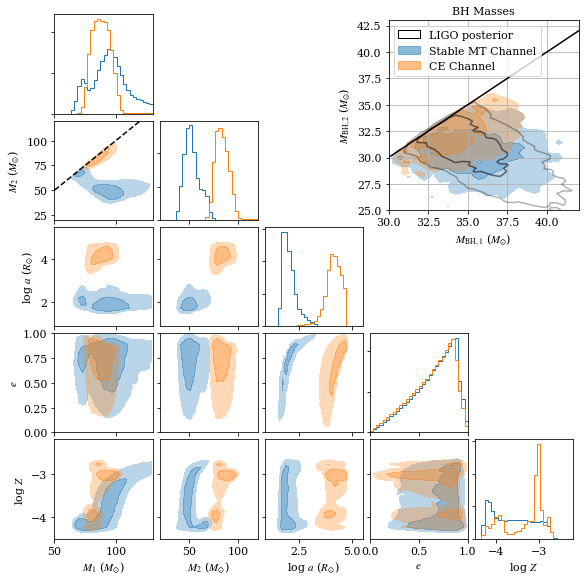

In [13]:
fig, ax = plt.subplots(5,5, figsize=(8,8))


ranges = [(50, 130), (20, 120), (0.9, 5.5), (0, 1), (-4.5, -2.2)]
labels = [r'$M_1$ ($M_{\odot}$)', r'$M_2$ ($M_{\odot}$)', r'log $a$ ($R_{\odot}$)', r'$e$', r'log $Z$']

models = [condensed_std_short[MT_std_short == 1], condensed_std_long[MT_std_long != 1]]
models_derived = [derived_std_short[MT_std_short == 1], derived_std_long[MT_std_long != 1]]
# models = [std_short_condensed, std_long_condensed]
# models_derived = [std_short_derived, std_long_derived]
# models = [std_short_condensed, std_long_condensed[idx_2], std_long_condensed[idx_0]]
#models_derived = [std_short_derived, std_long_derived[idx_2], std_long_derived[idx_0]]
colors = ['C0', 'C1']
# models = [alph5_condensed, qc2_condensed, facc1_condensed]
# colors = ['C0', 'C1', 'C2']

# corner_2(models, colors, ranges, labels, ax=ax)



# idx_good = np.where(np.log10(likelihood[idxs[0]]) > 4.5)[0]
# corner_2(models, colors, ranges, labels, ax=ax, 
#          points=std_BHBH_condensed[idxs[0]][idx_good], 
#          points_colors=np.log10(likelihood[idxs[0]][idx_good]))
corner_2(models, colors, ranges, labels, ax=ax)




# idx_good = np.where(np.log10(likelihood[idxs[5]]) > 4.5)[0]
# corner_2(models, colors, ranges, labels, ax=ax, 
#          points=std_BHBH_condensed[idxs[5]][idx_good], 
#          points_colors=np.log10(likelihood[idxs[5]][idx_good]))




# Add the posterior comparison with BH-BH masses
left, bottom, width, height = [0.66, 0.64, 0.33, 0.33]
# left, bottom, width, height = [0.62, 0.6, 0.33, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.grid()
ax2.plot([0, 100], [0, 100], color='k')
ax2.set_xlim(30, 42)
ax2.set_ylim(25, 43)
ax2.set_xlabel(r"$M_{\rm BH,1}$ ($M_{\odot}$)")
ax2.set_ylabel(r"$M_{\rm BH,2}$ ($M_{\odot}$)")
ax2.set_title('BH Masses')


# Make sure M1 is most massive BH
for i, model in enumerate(models_derived):
    M1 = copy.deepcopy(model['M1'])
    M2 = copy.deepcopy(model['M2'])
    idx = np.where(M1 < M2)[0]
    M1[idx] = copy.deepcopy(model['M2'][idx])
    M2[idx] = copy.deepcopy(model['M1'][idx])

    hist2d(M1, M2, levels=[0.5, 0.9], ax=ax2, color=colors[i])


# Plot LIGO constraints
LIGO_M1 = (ran_vals[1]*max_M_tot) / (1 + ran_vals[0])
LIGO_M2 = ran_vals[0] * LIGO_M1
hist2d(LIGO_M1, LIGO_M2, bins=50, levels=[0.5, 0.9], filled=False, color='k', ax=ax2)

legend_elements = [Patch(facecolor='w', edgecolor='k',
                         label='LIGO posterior'),
                   Patch(facecolor='C0', edgecolor='C0', alpha=0.5,
                         label='Stable MT Channel'),
                   Patch(facecolor='C1', edgecolor='C1', alpha=0.5,
                         label='CE Channel')]
#                    Patch(facecolor='C2', edgecolor='C2',
#                          label='Double CE Scenario')]

ax2.legend(handles=legend_elements, loc=2)



plt.subplots_adjust(hspace=0.07, wspace=0.07, left=0.08, right=0.98, bottom=0.07, top=0.98)
plt.savefig(figure_dir + "corner_std_models.pdf")
# plt.show()

<ipython-input-91-936d3beba3dc>:13: RuntimeWarning: divide by zero encountered in log10
  idx = np.intersect1d(idx, np.where(np.log10(likelihood) > 4)[0])


log a 1.7079407116896275
84.23036143466108 47.17329873216095 3.683058957481201 0.41841418923677764 (16.46123423457095, 0.8157896886784053, 0.24488015329754864, 5.6106096082210835) (11.599479101247363, 2.821748767705888, 3.1157951121018517, 0.9758940071858548) 0.00013816668375237837


<ipython-input-91-936d3beba3dc>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


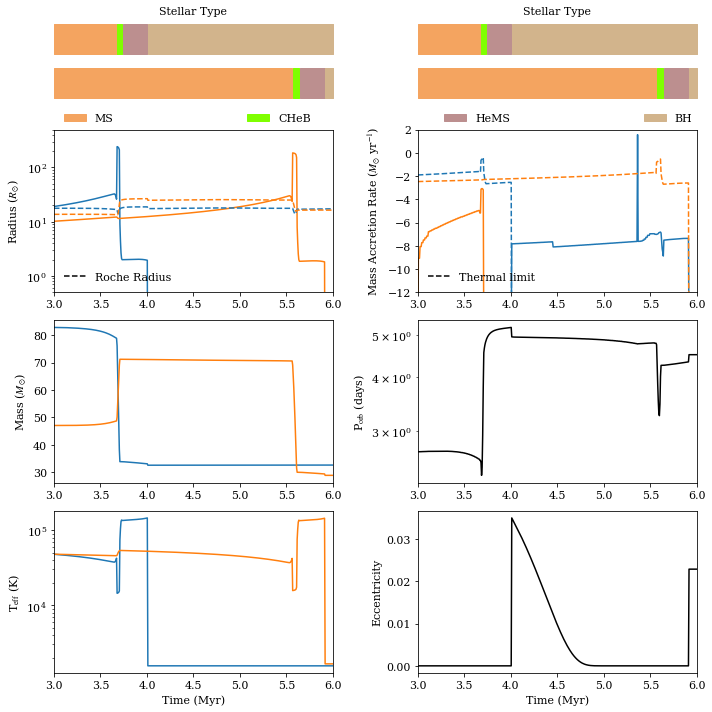

In [91]:
from dart_board.plot_system_evolution import evolve_and_plot, evolve_binary


# Case A MT
# idx = np.where(std_BHBH_condensed[:,2] > 2.5)[0]
# idx = np.intersect1d(idx, np.where(std_BHBH_condensed[:,2] < 3.4)[0])
# idx = np.intersect1d(idx, np.where(std_BHBH_condensed[:,3] > 0.8)[0])
# idx = np.intersect1d(idx, np.where(np.log10(likelihood) > 4)[0])

# Case B MT
idx = np.where(std_BHBH_condensed[:,2] < 2)[0]
idx = np.intersect1d(idx, np.where(std_BHBH_condensed[:,3] < 0.5)[0])
idx = np.intersect1d(idx, np.where(np.log10(likelihood) > 4)[0])


i = idx[10]



chain = std_BHBH_chains[i]
derived = std_BHBH_derived[i]

print("log a", chain[2])


M1, M2 = chain[0], chain[1]
a = 10**chain[2]
P_orb = A_to_P(M1, M2, a)
ecc = chain[3]
v_kick_1, theta_kick_1, phi_kick_1, omega_kick_1 = chain[4:8]
v1_kick = (v_kick_1, theta_kick_1, phi_kick_1, omega_kick_1)
v_kick_2, theta_kick_2, phi_kick_2, omega_kick_2 = chain[8:12]
v2_kick = (v_kick_2, theta_kick_2, phi_kick_2, omega_kick_2)
t_min, t_max = 3, 6
metallicity = 10**chain[12]


print(M1, M2, P_orb, ecc, v1_kick, v2_kick, metallicity)

model_kwargs = {'bhflag' : 3, 'acc_lim' : 0, 'f_acc' : 0.5}


fig = evolve_and_plot(evolve, M1, M2, P_orb, ecc, t_max, t_min=t_min,
                      v1_kick=v1_kick, v2_kick=v2_kick, metallicity=metallicity,
                      sys_obs={}, model_kwargs=model_kwargs)


# Calculate evolution
times, R1_out, R2_out, M1_out, M2_out, Teff1_out, Teff2_out, \
        Mdot1_out, Mdot2_out, P_orb_out, ecc_out, L1_out, L2_out, k1_out, \
        k2_out = evolve_binary(evolve, M1, M2, P_orb, ecc, t_min, t_max,
                               v1_kick, v2_kick, metallicity, model_kwargs=model_kwargs)


secyer = 3600*24*365.25
t_thermal_1 = (6.674e-8 * (M1_out*1.989e33)**2 / (R1_out*6.95e10) / (L1_out*3.84e33)) / secyer
t_thermal_2 = (6.674e-8 * (M2_out*1.989e33)**2 / (R2_out*6.95e10) / (L2_out*3.84e33)) / secyer
Mdot_thermal_1 = M1_out / t_thermal_1
Mdot_thermal_2 = M2_out / t_thermal_2


ax = fig.axes
ax[3].plot(times, np.log10(Mdot_thermal_1), color='C0', linestyle='dashed')
ax[3].plot(times, np.log10(Mdot_thermal_2), color='C1', linestyle='dashed')
ax[3].set_ylim(-12, 2)



legend_elements = [Line2D([0], [0], color='k', linestyle='dashed', label='Roche Radius')]
ax[2].legend(handles=legend_elements, loc=3, frameon=False)

legend_elements = [Line2D([0], [0], color='k', linestyle='dashed', label='Thermal limit')]
ax[3].legend(handles=legend_elements, loc=3, frameon=False)






fig.tight_layout()

fig.savefig(figure_dir + "example_evolution_MT_sub2.pdf")
# fig.show()

<ipython-input-92-88ebf44a75ff>:8: RuntimeWarning: divide by zero encountered in log10
  idx = np.intersect1d(idx, np.where(np.log10(likelihood) > 4)[0])


log a 3.0410996275444138
87.82424551331695 45.364737300754285 365.6087869306814 0.9668430682749569 (6.532194368081543, 2.532175153482036, 2.206755272480714, 1.8097981818019582) (19.882702173773033, 1.2002582739792127, 0.746236590116866, 4.408720088983487) 5.5383103605742605e-05


<ipython-input-92-88ebf44a75ff>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


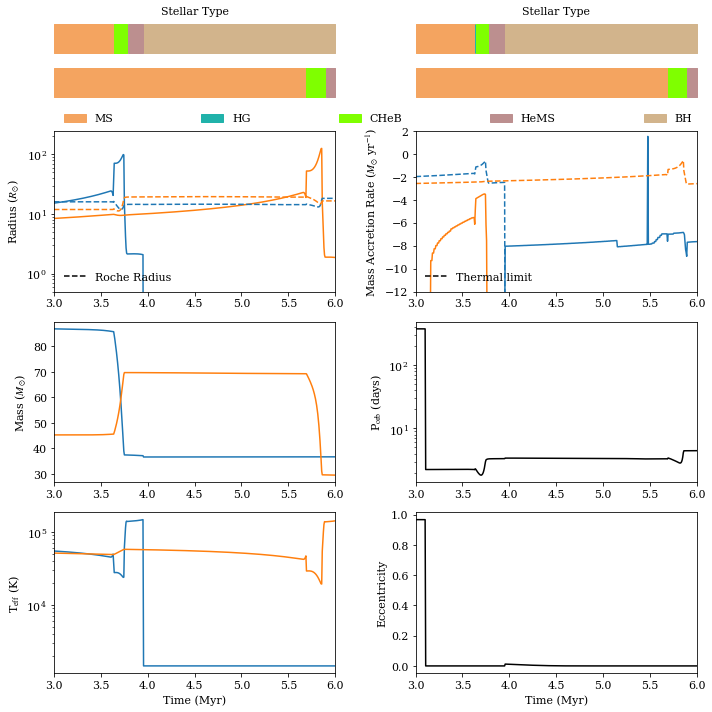

In [92]:
from dart_board.plot_system_evolution import evolve_and_plot, evolve_binary


# Case A MT
idx = np.where(std_BHBH_condensed[:,2] > 2.5)[0]
idx = np.intersect1d(idx, np.where(std_BHBH_condensed[:,2] < 3.4)[0])
idx = np.intersect1d(idx, np.where(std_BHBH_condensed[:,3] > 0.8)[0])
idx = np.intersect1d(idx, np.where(np.log10(likelihood) > 4)[0])

# Case B MT
# idx = np.where(std_BHBH_condensed[:,2] < 2)[0]
# idx = np.intersect1d(idx, np.where(std_BHBH_condensed[:,3] < 0.5)[0])
# idx = np.intersect1d(idx, np.where(np.log10(likelihood) > 4)[0])


i = idx[10]



chain = std_BHBH_chains[i]
derived = std_BHBH_derived[i]

print("log a", chain[2])


M1, M2 = chain[0], chain[1]
a = 10**chain[2]
P_orb = A_to_P(M1, M2, a)
ecc = chain[3]
v_kick_1, theta_kick_1, phi_kick_1, omega_kick_1 = chain[4:8]
v1_kick = (v_kick_1, theta_kick_1, phi_kick_1, omega_kick_1)
v_kick_2, theta_kick_2, phi_kick_2, omega_kick_2 = chain[8:12]
v2_kick = (v_kick_2, theta_kick_2, phi_kick_2, omega_kick_2)
t_min, t_max = 3, 6
metallicity = 10**chain[12]


print(M1, M2, P_orb, ecc, v1_kick, v2_kick, metallicity)

model_kwargs = {'bhflag' : 3, 'acc_lim' : 0, 'f_acc' : 0.5}


fig = evolve_and_plot(evolve, M1, M2, P_orb, ecc, t_max, t_min=t_min,
                      v1_kick=v1_kick, v2_kick=v2_kick, metallicity=metallicity,
                      sys_obs={}, model_kwargs=model_kwargs)


# Calculate evolution
times, R1_out, R2_out, M1_out, M2_out, Teff1_out, Teff2_out, \
        Mdot1_out, Mdot2_out, P_orb_out, ecc_out, L1_out, L2_out, k1_out, \
        k2_out = evolve_binary(evolve, M1, M2, P_orb, ecc, t_min, t_max,
                               v1_kick, v2_kick, metallicity, model_kwargs=model_kwargs)


secyer = 3600*24*365.25
t_thermal_1 = (6.674e-8 * (M1_out*1.989e33)**2 / (R1_out*6.95e10) / (L1_out*3.84e33)) / secyer
t_thermal_2 = (6.674e-8 * (M2_out*1.989e33)**2 / (R2_out*6.95e10) / (L2_out*3.84e33)) / secyer
Mdot_thermal_1 = M1_out / t_thermal_1
Mdot_thermal_2 = M2_out / t_thermal_2


ax = fig.axes
ax[3].plot(times, np.log10(Mdot_thermal_1), color='C0', linestyle='dashed')
ax[3].plot(times, np.log10(Mdot_thermal_2), color='C1', linestyle='dashed')
ax[3].set_ylim(-12, 2)



legend_elements = [Line2D([0], [0], color='k', linestyle='dashed', label='Roche Radius')]
ax[2].legend(handles=legend_elements, loc=3, frameon=False)

legend_elements = [Line2D([0], [0], color='k', linestyle='dashed', label='Thermal limit')]
ax[3].legend(handles=legend_elements, loc=3, frameon=False)






fig.tight_layout()

fig.savefig(figure_dir + "example_evolution_MT_sub1.pdf")
# fig.show()

In [95]:
def calc_evolution(chain, derived):


    M1, M2 = chain[0], chain[1]
    a = 10**chain[2]
    P_orb = A_to_P(M1, M2, a)
    ecc = chain[3]
    v_kick_1, theta_kick_1, phi_kick_1, omega_kick_1 = chain[4:8]
    v_kick_2, theta_kick_2, phi_kick_2, omega_kick_2 = chain[8:12]
    time = 100
    metallicity = 10**chain[12]

    model_kwargs = {'bhflag' : 3, 'acc_lim': 0, 'f_acc' : 0.5}

    bcm, bpp = evolve(M1,
                      M2,
                      P_orb,
                      ecc,
                      v_kick_1,
                      theta_kick_1,
                      phi_kick_1,
                      omega_kick_1,
                      v_kick_2,
                      theta_kick_2,
                      phi_kick_2,
                      omega_kick_2,
                      time,
                      metallicity,
                      return_evolution=True,
                      bhflag=3,
                      acc_lim=0,
                      f_acc=0.5,
                      alpha1=1)


    SN_flag = 0
    MT_flag = 0
    print()
    for line in bpp:
        print("%.2f"%line['tphys'][0], "%i"%line['kstar_1'][0], "%i"%line['kstar_2'][0], 
              "%.2f"%line['mass_1'][0], "%.2f"%line['mass_2'][0], 
              "%.2f"%line['rad_1'][0], "%.2f"%line['rad_2'][0],
              "%.2f"%line['sep'][0], "%.2f"%line['ecc'][0],
              "%i"%line['evol_type'][0])

        if line['evol_type'][0] == 15: SN_flag = 1

        # Stable MT
        if SN_flag == 1 and line['evol_type'][0] == 3:
            MT_flag = 1
        if SN_flag == 1 and line['evol_type'][0] == 7:
            MT_flag = 2

            
            
            


# Case A MT
idx = np.where(std_BHBH_condensed[:,2] > 2.5)[0]
idx = np.intersect1d(idx, np.where(std_BHBH_condensed[:,2] < 3.4)[0])
idx = np.intersect1d(idx, np.where(std_BHBH_condensed[:,3] > 0.8)[0])
idx = np.intersect1d(idx, np.where(np.log10(likelihood) > 4)[0])

i = idx[10]

print("Case C MT")

chain = std_BHBH_chains[i]
derived = std_BHBH_derived[i]
calc_evolution(chain, derived)
print()


# Case B MT
idx = np.where(std_BHBH_condensed[:,2] < 2)[0]
idx = np.intersect1d(idx, np.where(std_BHBH_condensed[:,3] < 0.5)[0])
idx = np.intersect1d(idx, np.where(np.log10(likelihood) > 4)[0])


i = idx[10]

print("Case B MT")

chain = std_BHBH_chains[i]
derived = std_BHBH_derived[i]
calc_evolution(chain, derived)





# print(MT_flag)
# print(derived.dtype.names)
# print(derived)

Case C MT

0.00 1 1 87.82 45.36 8.62 6.09 1098.46 0.97 1
3.10 1 1 86.76 45.24 16.05 8.61 36.75 0.00 3
3.64 2 1 85.71 45.57 17.83 9.87 36.55 0.00 2
3.64 4 1 85.64 45.61 70.95 9.87 37.41 0.00 2
3.75 4 1 37.41 69.68 13.75 9.62 43.34 0.00 4
3.78 7 1 37.40 69.68 2.14 9.68 44.37 0.00 2
3.95 7 1 37.09 69.66 2.08 10.02 44.56 0.00 15
3.95 14 1 36.59 69.66 0.00 10.02 45.08 0.01 2
5.48 14 1 36.61 69.29 0.00 19.19 44.10 0.00 3
5.69 14 1 36.63 69.23 0.00 17.76 44.14 0.00 4
5.69 14 2 36.63 69.23 0.00 17.18 44.14 0.00 2
5.69 14 2 36.63 69.23 0.00 19.49 44.77 0.00 3
5.69 14 4 36.63 69.21 0.00 52.52 45.14 0.00 2
5.86 14 4 36.65 29.60 0.00 15.78 45.98 0.00 4
5.89 14 7 36.65 29.60 0.00 1.89 45.98 0.00 2
6.04 14 7 36.65 29.43 0.00 1.81 46.08 0.00 16
6.04 14 14 36.65 28.93 0.00 0.00 44.17 0.05 2
100.00 14 14 36.65 28.93 0.00 0.00 44.14 0.05 10

Case B MT

0.00 1 1 84.23 47.17 8.84 6.64 51.01 0.42 1
2.86 1 1 82.85 47.09 17.66 9.86 41.19 0.00 3
3.68 2 1 78.83 48.77 23.84 12.18 39.72 0.00 2
3.68 4 1 78.32 49.

<ipython-input-95-c633aab963b3>:63: RuntimeWarning: divide by zero encountered in log10
  idx = np.intersect1d(idx, np.where(np.log10(likelihood) > 4)[0])
<ipython-input-95-c633aab963b3>:78: RuntimeWarning: divide by zero encountered in log10
  idx = np.intersect1d(idx, np.where(np.log10(likelihood) > 4)[0])


<ipython-input-114-6a10360306d3>:20: RuntimeWarning: divide by zero encountered in log10
  idx_good = np.where(np.log10(likelihoods[2][idxs[2]]) > 4.5)[0]


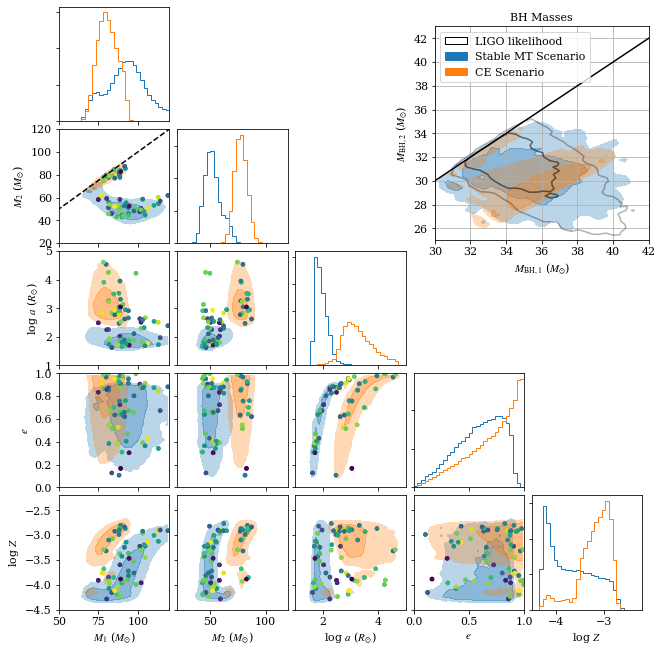

In [114]:
fig, ax = plt.subplots(5,5, figsize=(9,9))


ranges = [(50, 120), (20, 120), (1, 5), (0, 1), (-4.5, -2.2)]
labels = [r'$M_1$ ($M_{\odot}$)', r'$M_2$ ($M_{\odot}$)', r'log $a$ ($R_{\odot}$)', r'$e$', r'log $Z$']


# chains = [facc1_BHBH_chains, alph05_BHBH_chains, alph5_BHBH_chains, cemerge1_BHBH_chains,
#           qc2_BHBH_chains, std_BHBH_chains, sig150_BHBH_chains]
# deriveds = [facc1_BHBH_derived, alph05_BHBH_derived, alph5_BHBH_derived, cemerge1_BHBH_derived,
#             qc2_BHBH_derived, std_BHBH_derived, sig150_BHBH_derived]



models = [alph5_short_condensed, alph5_long_condensed]
models_derived = [alph5_short_derived, alph5_long_derived]
colors = ['C0', 'C1']


idx_good = np.where(np.log10(likelihoods[2][idxs[2]]) > 4.5)[0]
corner_2(models, colors, ranges, labels, ax=ax, 
         points=alph5_BHBH_condensed[idxs[2]][idx_good], 
         points_colors=np.log10(likelihoods[2][idxs[2]][idx_good]))



# Add the posterior comparison with BH-BH masses
left, bottom, width, height = [0.66, 0.62, 0.33, 0.33]
# left, bottom, width, height = [0.62, 0.6, 0.33, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.grid()
ax2.plot([0, 100], [0, 100], color='k')
ax2.set_xlim(30, 42)
ax2.set_ylim(25, 43)
ax2.set_xlabel(r"$M_{\rm BH,1}$ ($M_{\odot}$)")
ax2.set_ylabel(r"$M_{\rm BH,2}$ ($M_{\odot}$)")
ax2.set_title('BH Masses')





# Make sure M1 is most massive BH
for i, model in enumerate(models_derived):
    M1 = copy.deepcopy(model['M1'])
    M2 = copy.deepcopy(model['M2'])
    idx = np.where(M1 < M2)[0]
    M1[idx] = copy.deepcopy(model['M2'][idx])
    M2[idx] = copy.deepcopy(model['M1'][idx])

    hist2d(M1, M2, levels=[0.5, 0.9], ax=ax2, color=colors[i])


# Plot LIGO constraints
LIGO_M1 = (ran_vals[1]*max_M_tot) / (1 + ran_vals[0])
LIGO_M2 = ran_vals[0] * LIGO_M1
hist2d(LIGO_M1, LIGO_M2, bins=50, levels=[0.5, 0.9], filled=False, color='k', ax=ax2)

legend_elements = [Patch(facecolor='w', edgecolor='k',
                         label='LIGO likelihood'),
                   Patch(facecolor='C0', edgecolor='C0',
                         label='Stable MT Scenario'),
                   Patch(facecolor='C1', edgecolor='C1',
                         label='CE Scenario')]

ax2.legend(handles=legend_elements, loc=2)



plt.subplots_adjust(hspace=0.07, wspace=0.07, left=0.08, right=0.98, bottom=0.05, top=0.98)
# plt.savefig(figure_dir + "corner_ _models.pdf")
plt.show()

### Plot PT results

In [23]:
root = "../150914_PT/150914"

std_short_PT_chains, std_short_PT_derived, std_short_PT_condensed, std_short_MT = get_flattened_data(root, 'std_short', PT=True)
std_long_PT_chains, std_long_PT_derived, std_long_PT_condensed, std_long_MT = get_flattened_data(root, 'std_long', PT=True)

<ipython-input-227-399d1aa20352>:38: RuntimeWarning: divide by zero encountered in log10
  idx_good = np.where(np.log10(likelihood[idxs[0]]) > 4)[0]


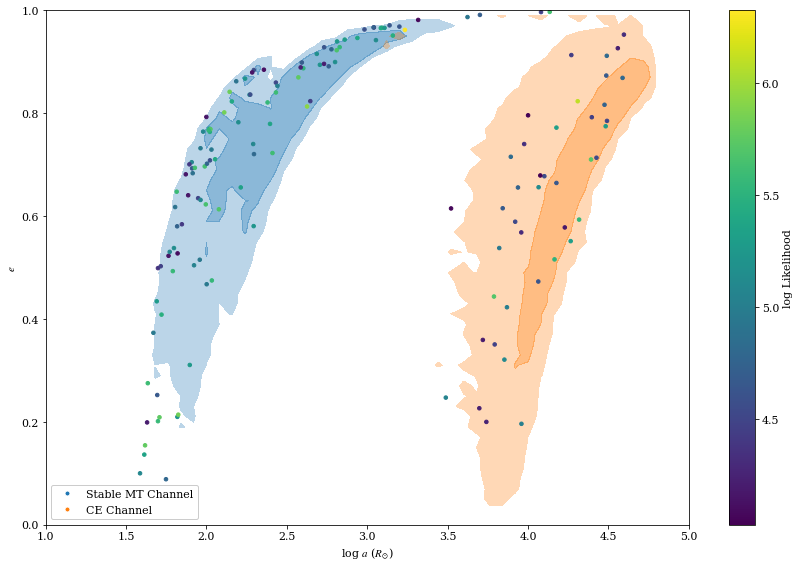

In [227]:
plt.figure(figsize=(12, 8))


# std model
chain = std_BHBH_chains
short_chain = std_short_PT_chains
long_chain = std_long_PT_chains
# short_chain = std_short_chains
# long_chain = std_long_chains
likelihood = likelihoods[0]


ax = plt.gca()


hist2d(short_chain[:,2], 
       short_chain[:,3], 
       xrange=(1,5), 
       yrange=(0,1), 
       ax=ax,
       color='C0',
       bins=50,
       levels=[0.5, 0.9])


hist2d(long_chain[:,2], 
       long_chain[:,3], 
       xrange=(1,5), 
       yrange=(0,1), 
       ax=ax,
       color='C1',
       bins=50,
       levels=[0.5, 0.9])




idx_good = np.where(np.log10(likelihood[idxs[0]]) > 4)[0]

# for i in range(len(idxs[5])):
plt.scatter(chain[idxs[0],2][idx_good], 
            chain[idxs[0],3][idx_good], 
            marker='.', 
            s=50,
            c=np.log10(likelihood[idxs[0]][idx_good]))



plt.colorbar(label='log Likelihood')



plt.xlim(1,5)
plt.ylim(0,1)

plt.xlabel(r'log $a$ ($R_{\odot}$)')
plt.ylabel(r'$e$')


legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='C0', markersize=5, 
                         label='Stable MT Channel'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='C1', markersize=5, 
                         label='CE Channel')]

plt.legend(handles=legend_elements, loc=3, framealpha=1)


# ax.arrow(3.3, 0.85, -0.3, 0.05, head_width=0.05, head_length=0.1, fc='k', ec='k')
# plt.text(3.3, 0.83, "Case C MT", fontsize=14)

# ax.arrow(2.5, 0.6, -0.3, 0.05, head_width=0.05, head_length=0.1, fc='k', ec='k')
# plt.text(2.5, 0.58, "Case B MT", fontsize=14)



plt.tight_layout()
# plt.savefig(figure_dir + "std_P_orb_ecc_with_points_PT.pdf")
plt.show()

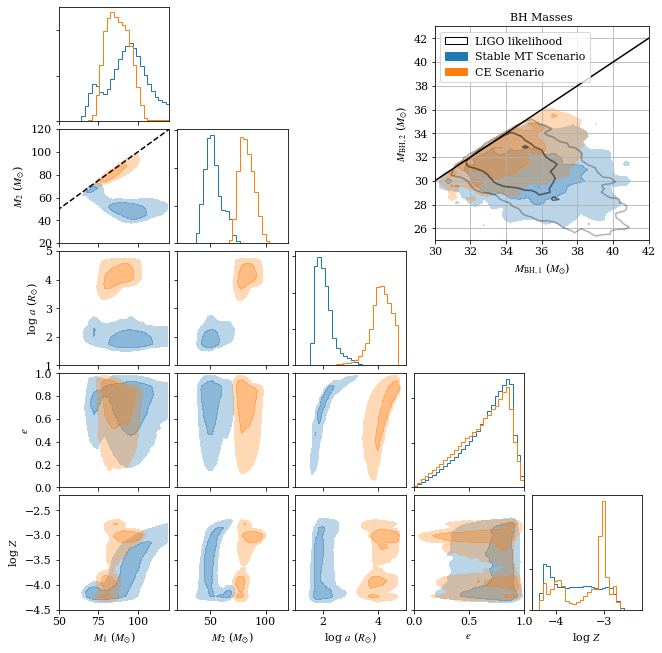

In [25]:
fig, ax = plt.subplots(5,5, figsize=(9,9))


ranges = [(50, 120), (20, 120), (1, 5), (0, 1), (-4.5, -2.2)]
labels = [r'$M_1$ ($M_{\odot}$)', r'$M_2$ ($M_{\odot}$)', r'log $a$ ($R_{\odot}$)', r'$e$', r'log $Z$']


# chains = [facc1_BHBH_chains, alph05_BHBH_chains, alph5_BHBH_chains, cemerge1_BHBH_chains,
#           qc2_BHBH_chains, std_BHBH_chains, sig150_BHBH_chains]
# deriveds = [facc1_BHBH_derived, alph05_BHBH_derived, alph5_BHBH_derived, cemerge1_BHBH_derived,
#             qc2_BHBH_derived, std_BHBH_derived, sig150_BHBH_derived]


idx1 = np.where(std_short_MT == 1)[0]
idx2 = np.where(std_long_MT != 1)[0]

models = [std_short_PT_condensed[idx1], std_long_PT_condensed[idx2]]
models_derived = [std_short_PT_derived[idx1], std_long_PT_derived[idx2]]
colors = ['C0', 'C1']


# chain[idxs[0],2][idx_good]
# likelihood[idxs[0]][idx_good]

# idx_good = np.where(np.log10(likelihoods[5][idxs[5]]) > 4.5)[0]
corner_2(models, colors, ranges, labels, ax=ax) 
#          points=std_BHBH_condensed[idxs[0]][idx_good], 
#          points_colors=np.log10(likelihood[idxs[0]][idx_good]))



# Add the posterior comparison with BH-BH masses
left, bottom, width, height = [0.66, 0.62, 0.33, 0.33]
# left, bottom, width, height = [0.62, 0.6, 0.33, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.grid()
ax2.plot([0, 100], [0, 100], color='k')
ax2.set_xlim(30, 42)
ax2.set_ylim(25, 43)
ax2.set_xlabel(r"$M_{\rm BH,1}$ ($M_{\odot}$)")
ax2.set_ylabel(r"$M_{\rm BH,2}$ ($M_{\odot}$)")
ax2.set_title('BH Masses')





# Make sure M1 is most massive BH
for i, model in enumerate(models_derived):
    M1 = copy.deepcopy(model['M1'])
    M2 = copy.deepcopy(model['M2'])
    idx = np.where(M1 < M2)[0]
    M1[idx] = copy.deepcopy(model['M2'][idx])
    M2[idx] = copy.deepcopy(model['M1'][idx])

    hist2d(M1, M2, levels=[0.5, 0.9], ax=ax2, color=colors[i])


# Plot LIGO constraints
LIGO_M1 = (ran_vals[1]*max_M_tot) / (1 + ran_vals[0])
LIGO_M2 = ran_vals[0] * LIGO_M1
hist2d(LIGO_M1, LIGO_M2, bins=50, levels=[0.5, 0.9], filled=False, color='k', ax=ax2)

legend_elements = [Patch(facecolor='w', edgecolor='k',
                         label='LIGO likelihood'),
                   Patch(facecolor='C0', edgecolor='C0',
                         label='Stable MT Scenario'),
                   Patch(facecolor='C1', edgecolor='C1',
                         label='CE Scenario')]

ax2.legend(handles=legend_elements, loc=2)



plt.subplots_adjust(hspace=0.07, wspace=0.07, left=0.08, right=0.98, bottom=0.05, top=0.98)
plt.savefig(figure_dir + "corner_std_models_PT_pts.pdf")
# plt.show()

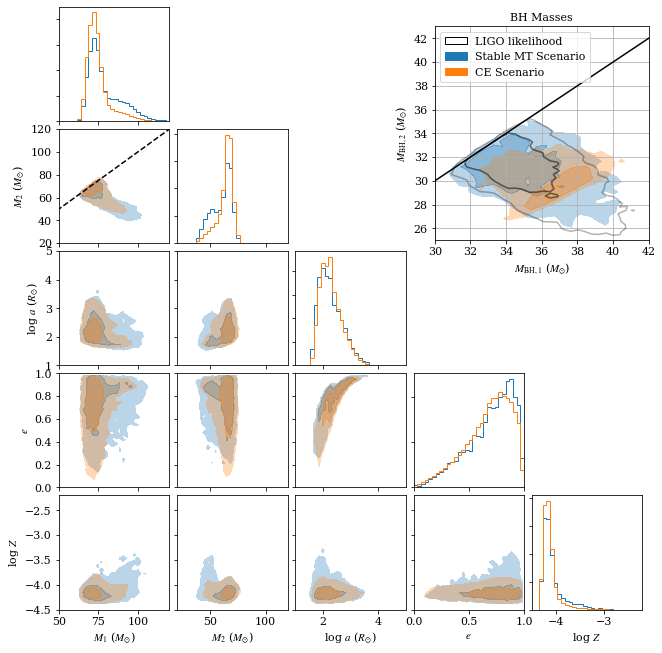

In [231]:
fig, ax = plt.subplots(5,5, figsize=(9,9))


ranges = [(50, 120), (20, 120), (1, 5), (0, 1), (-4.5, -2.2)]
labels = [r'$M_1$ ($M_{\odot}$)', r'$M_2$ ($M_{\odot}$)', r'log $a$ ($R_{\odot}$)', r'$e$', r'log $Z$']


# chains = [facc1_BHBH_chains, alph05_BHBH_chains, alph5_BHBH_chains, cemerge1_BHBH_chains,
#           qc2_BHBH_chains, std_BHBH_chains, sig150_BHBH_chains]
# deriveds = [facc1_BHBH_derived, alph05_BHBH_derived, alph5_BHBH_derived, cemerge1_BHBH_derived,
#             qc2_BHBH_derived, std_BHBH_derived, sig150_BHBH_derived]

idx1 = np.where(std_short_PT_derived['M1'] > std_short_PT_derived['M2'])[0]
idx2 = np.where(std_short_PT_derived['M1'] < std_short_PT_derived['M2'])[0]

models = [std_short_PT_condensed[idx1], std_short_PT_condensed[idx2]]
models_derived = [std_short_PT_derived[idx1], std_short_PT_derived[idx2]]
colors = ['C0', 'C1']


# chain[idxs[0],2][idx_good]
# likelihood[idxs[0]][idx_good]

# idx_good = np.where(np.log10(likelihoods[5][idxs[5]]) > 4.5)[0]
corner_2(models, colors, ranges, labels, ax=ax)



# Add the posterior comparison with BH-BH masses
left, bottom, width, height = [0.66, 0.62, 0.33, 0.33]
# left, bottom, width, height = [0.62, 0.6, 0.33, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.grid()
ax2.plot([0, 100], [0, 100], color='k')
ax2.set_xlim(30, 42)
ax2.set_ylim(25, 43)
ax2.set_xlabel(r"$M_{\rm BH,1}$ ($M_{\odot}$)")
ax2.set_ylabel(r"$M_{\rm BH,2}$ ($M_{\odot}$)")
ax2.set_title('BH Masses')





# Make sure M1 is most massive BH
for i, model in enumerate(models_derived):
    M1 = copy.deepcopy(model['M1'])
    M2 = copy.deepcopy(model['M2'])
    idx = np.where(M1 < M2)[0]
    M1[idx] = copy.deepcopy(model['M2'][idx])
    M2[idx] = copy.deepcopy(model['M1'][idx])

    hist2d(M1, M2, levels=[0.5, 0.9], ax=ax2, color=colors[i])


# Plot LIGO constraints
LIGO_M1 = (ran_vals[1]*max_M_tot) / (1 + ran_vals[0])
LIGO_M2 = ran_vals[0] * LIGO_M1
hist2d(LIGO_M1, LIGO_M2, bins=50, levels=[0.5, 0.9], filled=False, color='k', ax=ax2)

legend_elements = [Patch(facecolor='w', edgecolor='k',
                         label='LIGO likelihood'),
                   Patch(facecolor='C0', edgecolor='C0',
                         label='Stable MT Scenario'),
                   Patch(facecolor='C1', edgecolor='C1',
                         label='CE Scenario')]

ax2.legend(handles=legend_elements, loc=2)



plt.subplots_adjust(hspace=0.07, wspace=0.07, left=0.08, right=0.98, bottom=0.05, top=0.98)
# plt.savefig(figure_dir + "corner_std_models_PT_pts.pdf")
plt.show()

In [95]:
PT_chains = np.load("../data/150914_PT/150914_chains_std_short_PT.npy")
PT_derived = np.load("../data/150914_PT/150914_derived_std_short_PT.npy")
print(PT_chains.shape)

(4, 320, 1000, 13)


In [96]:
n_temps, n_walkers, n_steps, n_var = PT_chains.shape

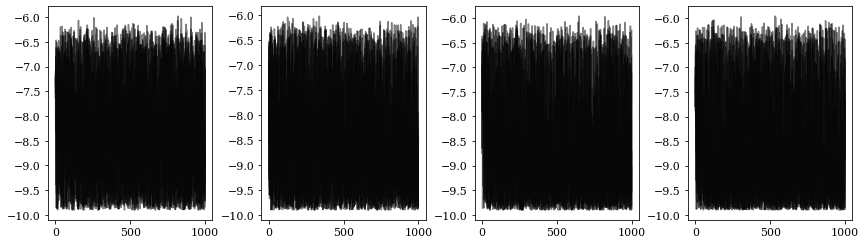

In [97]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3.5))

for i in range(n_temps):
    for j in range(5):
        ax[i].plot(np.arange(n_steps), PT_chains[i,j,:,-1], color='k', alpha=0.5)
    
plt.tight_layout()
plt.show()

In [187]:
prior_kwargs = {'kick_sigma' : 10}
model_kwargs = {'bhflag' : 3, 'acc_lim': 0, 'f_acc' : 0.5}


pub150914 = dart_board.DartBoard("BHBH", 
                                 evolve_binary=evolve, 
                                 nwalkers=320, 
                                 ntemps=4, 
                                 prior_kwargs=prior_kwargs, 
                                 model_kwargs = model_kwargs, 
                                 ln_prior_t=None, 
                                 ln_prior_z=my_function_Z, 
                                 ln_likelihood_function=nlog_likelihood,
                                 thin=1)

lprior = np.zeros(n_steps)
for i in range(n_steps):
    lprior[i] = dart_board.priors.ln_prior(PT_chains[0,0,i], pub150914)

likelihood = calc_likelihood(std_short_PT_chains[0:200], std_short_PT_derived[0:200], idx=None)


In [167]:
print(std_short_PT_chains[0:10,0])
print(np.exp(PT_chains[0,0,0:10,0]))

[70.50068604 74.78602264 67.5188962  70.62728677 67.07855686 71.69657708
 80.29295017 71.49137978 64.05406586 75.26700441]
[70.50068604 74.78602264 67.5188962  70.62728677 67.07855686 71.69657708
 80.29295017 71.49137978 64.05406586 75.26700441]


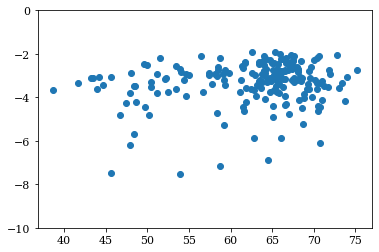

In [191]:
log_posterior = np.log10(likelihood) + np.log10(np.exp(lprior))

plt.scatter(np.exp(PT_chains[0,0,:,1]), log_posterior)

plt.ylim(-10,0)

plt.show()

(-10.0, 0.0)

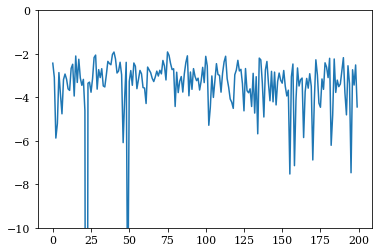

In [193]:
plt.plot(log_posterior)
plt.ylim(-10, 0)

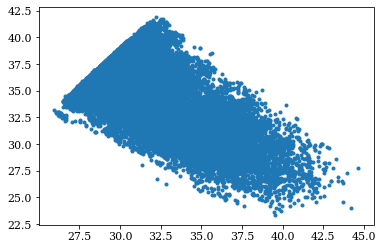

In [196]:
plt.scatter(std_short_PT_derived['M1'], std_short_PT_derived['M2'], marker='.')

plt.show()